In [55]:
#Importing Necessary Libraries
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model  import Ridge,Lasso,RidgeCV, LassoCV, ElasticNet, ElasticNetCV, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import KNNImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from sklearn.metrics import roc_curve, roc_auc_score, multilabel_confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
import seaborn as sns
import glob
import os.path

In [2]:
#Function to merge all the files into single dataframe
def data_gather(filepath):
    all_files = glob.glob(filepath, recursive = True) #glob function to open all files in the given directory and its sub-directories

    li = []
    
    ext = [".ini", ".txt"]
    for filename in all_files:
        if not filename.endswith(tuple(ext)):
            df = pd.read_csv(filename, names = ['Time', 'Acc_frontal_axis', 'Acc_vertical_axis', 'Acc_lateral_axis', 'Antenna_ID', 'RSSI', 'Phase', 'Frequency', 'Activity'])
            df['room'] = os.path.basename(os.path.dirname(filename)) #labeling the target variable with the sub-directory name
            df['gender'] = filename[-5] #getting Gender from the 5th character from last of the filename (last 4 characters will be '.csv')
            li.append(df)
    
    fdf = pd.concat(li, axis=0, ignore_index=True) #concatenating all files into a single dataframe
    fdf = fdf.replace(to_replace =["S1_Dataset"], value ="1") #S1 dataset has data of room 1
    fdf = fdf.replace(to_replace =["S2_Dataset"], value ="2") #S2 dataset has data of room 2
    fdf = fdf.replace(to_replace =["M"], value ="1") #Denoting Male gender as 1
    fdf = fdf.replace(to_replace =["F"], value ="0") #Denoting Femal gender as 0; String values are not accepted by Decision trees
    return fdf

In [3]:
#Reading data
fdf = data_gather(r"C:\Users\Manu\Documents\ineuron\Machine Learning\Datasets_Healthy_Older_People\**\*.csv")

### EDA

In [43]:
profile = ProfileReport(fdf)
profile.to_widgets()

Summarize dataset:   0%|          | 0/29 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

### Replacing zeros with nans to impute

In [6]:
# There are many zeros in Time column. Logically time can't be 0 for any activity. So we replace 0 with NaNs for imputation
fdf['Time'] = fdf['Time'].replace({'0':np.nan, 0:np.nan})

### Assigning separate dataframe for Decision Trees

In [7]:
#Decision Trees don't need missing value imputation, outlier removal, multicollinearity treatment and normalization. 
#So we will copy the dataframe into a separate variable for Decision Trees. We will not perform any of the above operations on this dataframe. 
fdf_DT = fdf

### Treating Outliers

<AxesSubplot:>

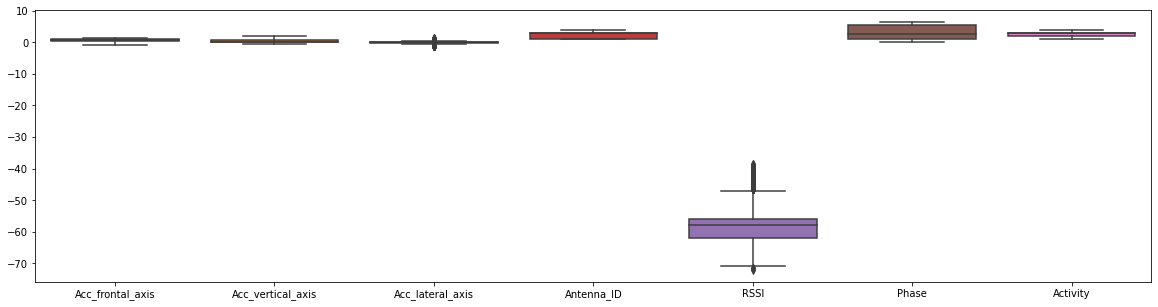

In [9]:
#Boxplots
fig ,ax  = plt.subplots(figsize = (20,5))
sns.boxplot(data = fdf.drop(columns=['Time', 'Frequency']) , ax = ax)

In [8]:
#Function to replace outliers with NaNs
def outlier_removal(data, uq, lq):
        def outlier_limits(col):
            Q3, Q1 = np.nanpercentile(col, [uq,lq])
            IQR= Q3-Q1
            UL= Q3+1.5*IQR
            LL= Q1-1.5*IQR
            return UL, LL

        outlier =[]
        for column in data.columns:
            if data[column].dtype != 'int64':
                UL, LL= outlier_limits(data[column])
                #for x in data[column]:
                    #if ((x> UL) or (x<LL)):
                        #outlier.append(x)
                data[column]= np.where((data[column] > UL) | (data[column] < LL), np.nan, data[column])

        return data

In [9]:
df.iloc[:,1:7] = outlier_removal(fdf.iloc[:,1:7], 75, 20)

NumExpr defaulting to 4 threads.


In [150]:
fdf.head()

,Time,Acc_frontal_axis,Acc_vertical_axis,Acc_lateral_axis,Antenna_ID,RSSI,Phase,Frequency,Activity,room,gender
0,NaN,0.27203,1.00820,-0.082102,1,-63.5,2.4252,924.25,1,R1,M
1,0.50,0.27203,1.00820,-0.082102,1,-63.0,4.7369,921.75,1,R1,M
2,1.50,0.44791,0.91636,-0.013684,1,-63.5,3.0311,923.75,1,R1,M
3,1.75,0.44791,0.91636,-0.013684,1,-63.0,2.0371,921.25,1,R1,M
4,2.50,0.34238,0.96229,-0.059296,1,-63.5,5.8920,920.25,1,R1,M


### Imputing NaNs/missing values

In [10]:
# Using Knn imputer to impute missing values instead of using mean, mode, median, etc.
imputer = KNNImputer()
fdf.loc[:, ~fdf.columns.isin(['Antenna_ID', 'room', 'gender', 'Activity'])] = imputer.fit_transform(fdf.loc[:, ~fdf.columns.isin(['Antenna_ID', 'room', 'gender', 'Activity'])])

<AxesSubplot:>

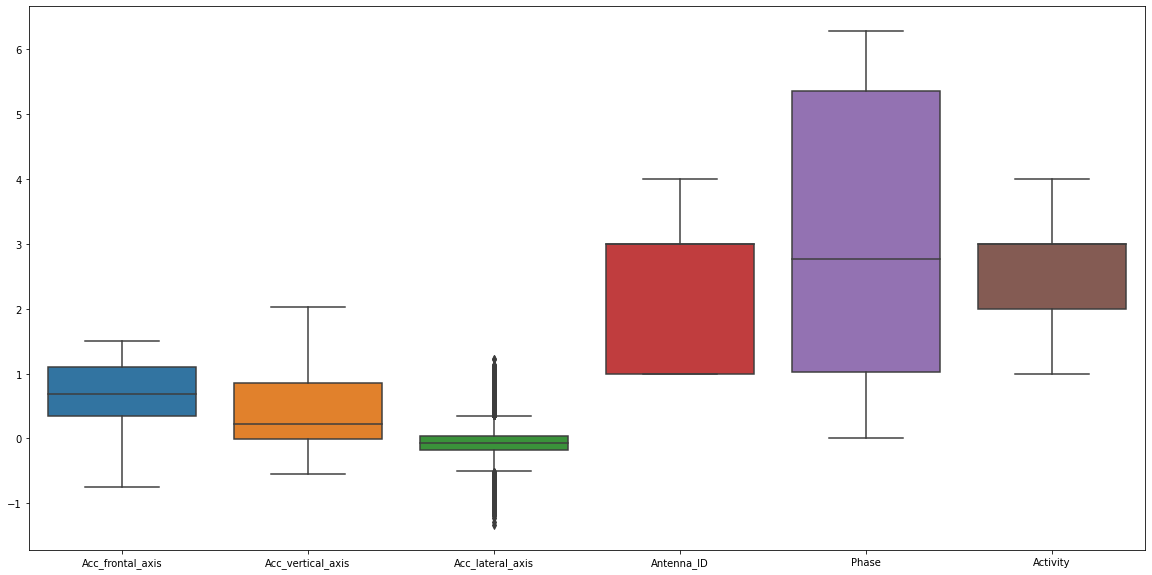

In [152]:
#Boxplots after imputation
fig ,ax  = plt.subplots(figsize = (20,10))
sns.boxplot(data = fdf.drop(columns=['Time', 'Frequency', 'RSSI']) , ax = ax)

### Rearranging columns

In [12]:
#Function to keep categorical variables adjacent to each other. This makes slicing and dicing data easy.
def rearrange(data, colindex1, colindex2):
    cols = data.columns.tolist()
    a,b = cols[colindex1], cols[colindex2]
    cols[colindex1]=b
    cols[colindex2]=a
    data=data[cols]
    return data

In [13]:
fdf = rearrange(fdf, 4, 7)

In [14]:
fdf.head()

,Time,Acc_frontal_axis,Acc_vertical_axis,Acc_lateral_axis,Frequency,RSSI,Phase,Antenna_ID,Activity,room,gender
0,0.075,0.27203,1.00820,-0.082102,924.25,-63.5,2.4252,1,1,1,1
1,0.500,0.27203,1.00820,-0.082102,921.75,-63.0,4.7369,1,1,1,1
2,1.500,0.44791,0.91636,-0.013684,923.75,-63.5,3.0311,1,1,1,1
3,1.750,0.44791,0.91636,-0.013684,921.25,-63.0,2.0371,1,1,1,1
4,2.500,0.34238,0.96229,-0.059296,920.25,-63.5,5.8920,1,1,1,1


### One hot encoding

In [9]:
#Number of categories in each categorical column
print(fdf['room'].unique())
print(fdf['Antenna_ID'].unique())
print(fdf['gender'].unique())

['R1' 'R2']
[1 4 3 2]
['M' 'F']


In [15]:
#Dummy variable creation for KNN, SVC and Logistic regression models
fdf = pd.get_dummies(fdf, columns = ['Antenna_ID', 'room', 'gender'])

### Creating independent and dependent variables

In [16]:
y = fdf['Activity']
x = fdf.drop(columns=['Activity'])

### Treating Multicollinearity

In [14]:
def vif_score(x):
    temp = x.iloc[:,0:7]
    scaler = StandardScaler()
    arr = scaler.fit_transform(temp)
    return pd.DataFrame([[temp.columns[i], variance_inflation_factor(arr,i)] for i in range(arr.shape[1])], columns=["FEATURE", "VIF_SCORE"])

In [15]:
vif_score(x.iloc[:,0:7])

,FEATURE,VIF_SCORE
0,Time,1.237714
1,Acc_frontal_axis,4.353273
2,Acc_vertical_axis,3.875909
3,Acc_lateral_axis,2.125789
4,Frequency,1.048328
5,RSSI,1.069617
6,Phase,1.008050


All VIF values are well under limit, i.e. 10. So we don't need to remove any variables.

### Normalizing Data

In [17]:
scaler = StandardScaler()
x.iloc[:,0:7]= pd.DataFrame(scaler.fit_transform(x.iloc[:,0:7]))

In [14]:
x.head()

,Time,Acc_frontal_axis,Acc_vertical_axis,Acc_lateral_axis,Frequency,RSSI,Phase,Antenna_ID_1,Antenna_ID_2,Antenna_ID_3,Antenna_ID_4,room_R1,room_R2,gender_F,gender_M
0,-1.162289,-1.092933,1.582195,0.308923,0.940671,-1.012185,-0.335471,1,0,0,0,1,0,0,1
1,-1.160638,-1.092933,1.582195,0.308923,-0.548237,-0.914133,0.723852,1,0,0,0,1,0,0,1
2,-1.156754,-0.658213,1.363027,0.465051,0.642890,-1.012185,-0.057821,1,0,0,0,1,0,0,1
3,-1.155783,-0.658213,1.363027,0.465051,-0.846019,-0.914133,-0.513315,1,0,0,0,1,0,0,1
4,-1.152869,-0.919050,1.472635,0.360966,-1.441583,-1.012185,1.253170,1,0,0,0,1,0,0,1


### Splitting data into train and test

In [18]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .20 , random_state = 144)

### Logistic Regression

We will use __Saga__ solver with __Elasticnet__ regularization to get the best results. Also, as it is a multi-class dataset, we will use multi-class = __multinomial__

In [46]:
lr_model = LogisticRegression(multi_class = 'multinomial')

In [47]:
lr_model.fit(x_train, y_train)

C:\Users\Manu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial')

In [48]:
lr_model.score(x_test, y_test)

0.9576733661653135

In [17]:
# Grid Search CV to find the best parameters for some hyperparameters
lr_grid_param = {"class_weight":['balanced',None],
             "warm_start":[True, False],
             "l1_ratio" : list(np.arange(0.0, 0.5, 0.1))
             }

In [18]:
lr_grid = GridSearchCV(estimator=lr_model, param_grid=lr_grid_param , cv = 5 , n_jobs=-1)

In [19]:
lr_grid.fit(x_train, y_train)

C:\Users\Manu\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=5,
             estimator=LogisticRegression(multi_class='multinomial',
                                          penalty='elasticnet', solver='saga'),
             n_jobs=-1,
             param_grid={'class_weight': ['balanced', None],
                         'l1_ratio': [0.0, 0.1, 0.2, 0.30000000000000004, 0.4],
                         'warm_start': [True, False]})

In [32]:
lr_grid.best_params_

{'class_weight': None, 'l1_ratio': 0.1, 'warm_start': True}

In [49]:
#After getting the best parameters from the GridSearch CV, we will use them to build the model. 
lr_best = LogisticRegression(penalty = 'elasticnet', l1_ratio = 0.1, solver='saga', warm_start = True, multi_class = 'multinomial')

In [50]:
lr_best.fit(x_train, y_train)

C:\Users\Manu\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(l1_ratio=0.1, multi_class='multinomial',
                   penalty='elasticnet', solver='saga', warm_start=True)

In [51]:
lr_best.score(x_test,y_test)

0.9576733661653135

_We haven't got any improvement in the model. Hence we can use default parameters for model creation._ 

In [52]:
#Predicting the y-values on test dataset
y_pred = lr_best.predict(x_test)

### Confusion matrix and classification report

In [53]:
#Creating multi-class confusion matrix
mcm = multilabel_confusion_matrix(y_test, y_pred)
mcm

array([[[11393,   352],
        [  152,  3129]],

       [[13898,   180],
        [  136,   812]],

       [[ 4654,    39],
        [   10, 10323]],

       [[14497,    65],
        [  338,   126]]], dtype=int64)

In [25]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.90      0.95      0.93      3281
           2       0.82      0.86      0.84       948
           3       1.00      1.00      1.00     10333
           4       0.66      0.27      0.38       464

    accuracy                           0.96     15026
   macro avg       0.84      0.77      0.79     15026
weighted avg       0.95      0.96      0.95     15026



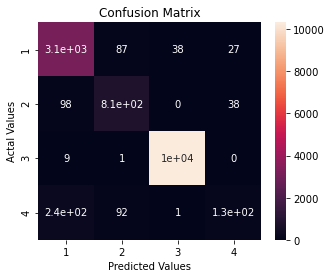

In [65]:
cm = confusion_matrix(y_test, y_pred)
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_fdf = pd.DataFrame(cm,
                     index = [1,2,3,4], 
                     columns = [1,2,3,4])
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_fdf, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

### SVM Kernel Classification

In [58]:
from sklearn.svm import SVC

In [59]:
#Creating a model with default parameters
svc= SVC()
svc.fit(x_train,y_train)

SVC()

In [23]:
svc.score(x_test,y_test)

0.9798349527485691

In [20]:
# GridSearch CV to search best parameters for SVC
svc_param ={"kernel":['linear', 'poly', 'rbf', 'sigmoid' ],
        'C':[0.1],
        'gamma':[.001]
    } 
svm_grid = GridSearchCV(svc, param_grid = svc_param , verbose=3)
svm_grid.fit(x_train,y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END .C=0.1, gamma=0.001, kernel=linear;, score=0.961 total time=  13.5s
[CV 2/5] END .C=0.1, gamma=0.001, kernel=linear;, score=0.960 total time=  12.6s
[CV 3/5] END .C=0.1, gamma=0.001, kernel=linear;, score=0.962 total time=  12.8s
[CV 4/5] END .C=0.1, gamma=0.001, kernel=linear;, score=0.961 total time=  12.8s
[CV 5/5] END .C=0.1, gamma=0.001, kernel=linear;, score=0.959 total time=  14.1s
[CV 1/5] END ...C=0.1, gamma=0.001, kernel=poly;, score=0.685 total time= 2.1min
[CV 2/5] END ...C=0.1, gamma=0.001, kernel=poly;, score=0.685 total time= 2.2min
[CV 3/5] END ...C=0.1, gamma=0.001, kernel=poly;, score=0.685 total time= 2.5min
[CV 4/5] END ...C=0.1, gamma=0.001, kernel=poly;, score=0.685 total time= 2.4min
[CV 5/5] END ...C=0.1, gamma=0.001, kernel=poly;, score=0.685 total time= 2.4min
[CV 1/5] END ....C=0.1, gamma=0.001, kernel=rbf;, score=0.897 total time= 2.5min
[CV 2/5] END ....C=0.1, gamma=0.001, kernel=rbf;,

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1], 'gamma': [0.001],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             verbose=3)

In [22]:
#Best parameters for SVC model obtained from GridSearch CV
svm_grid.best_params_

{'C': 0.1, 'gamma': 0.001, 'kernel': 'linear'}

In [60]:
#Using best parameters for another SVC model
svc_best = SVC(kernel = 'linear', C = 0.1, gamma = 0.001, decision_function_shape = 'ovo')

In [61]:
svc_best.fit(x_train, y_train)

SVC(C=0.1, decision_function_shape='ovo', gamma=0.001, kernel='linear')

In [62]:
svc_best.score(x_test, y_test)

0.9611340343404765

_The model score after using best parameters is lesser than using default parameters. Hence we will use default parameters._

In [63]:
#Predicting the y-values on test dataset
y_pred_svc = svc.predict(x_test)

In [64]:
#Creating a multi-class confusion matrix
mcm = multilabel_confusion_matrix(y_test, y_pred_svc)
mcm

array([[[11542,   203],
        [   34,  3247]],

       [[14013,    65],
        [    5,   943]],

       [[ 4664,    29],
        [   10, 10323]],

       [[14556,     6],
        [  254,   210]]], dtype=int64)

Here each 4*4 matrix is for each category in the Activity column.

In [26]:
print(classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

           1       0.94      0.99      0.96      3281
           2       0.94      0.99      0.96       948
           3       1.00      1.00      1.00     10333
           4       0.97      0.45      0.62       464

    accuracy                           0.98     15026
   macro avg       0.96      0.86      0.89     15026
weighted avg       0.98      0.98      0.98     15026



### K-Nearest Neighbours

In [68]:
#KNN model with default parameters
knn = KNeighborsClassifier()

In [28]:
knn.fit(x_train,y_train)

KNeighborsClassifier()

In [29]:
knn.score(x_test, y_test)

C:\Users\Manu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


0.9852256089444962

In [69]:
#GridSearch CV for hyperparameter tuning
knn_param  = {
    'n_neighbors':[3,9,15,21],
    'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size' : [10 , 20 , 30 , 40, 50],
    'p' : [1,2],
    'weights' : ['uniform', 'distance']    
}

In [72]:
knn_grid = GridSearchCV(knn, param_grid=knn_param )

In [74]:
knn_grid.fit(x_train, y_train)

C:\Users\Manu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\Manu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\Manu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\Manu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\Manu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\Manu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning:

C:\Users\Manu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\Manu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\Manu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\Manu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\Manu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\Manu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning:

C:\Users\Manu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\Manu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\Manu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\Manu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\Manu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\Manu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning:

C:\Users\Manu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\Manu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\Manu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\Manu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\Manu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\Manu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning:

C:\Users\Manu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\Manu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\Manu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\Manu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\Manu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\Manu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning:

C:\Users\Manu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\Manu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\Manu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\Manu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\Manu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\Manu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning:

C:\Users\Manu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\Manu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\Manu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\Manu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\Manu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\Manu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning:

C:\Users\Manu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\Manu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\Manu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\Manu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\Manu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\Manu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning:

C:\Users\Manu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\Manu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\Manu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\Manu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\Manu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\Manu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning:

C:\Users\Manu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\Manu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\Manu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\Manu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\Manu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\Manu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning:

KeyboardInterrupt: 

In [ ]:
#Best parameters for KNN model
knn_grid.best_params_

In [30]:
#Using best parameters to build the model
knn = KNeighborsClassifier(n_neighbors=3, p=1, weights='distance', leaf_size=10, algorithm='auto')

In [31]:
knn.fit(x_train, y_train)

KNeighborsClassifier(leaf_size=10, n_neighbors=3, p=1, weights='distance')

In [32]:
knn.score(x_test, y_test)

C:\Users\Manu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


0.9875549048316252

_There is a slight improvement in the KNN model after using the best parameters._

In [33]:
y_pred_knn = knn.predict(x_test)

C:\Users\Manu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


In [34]:
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           1       0.98      0.98      0.98      3281
           2       0.96      0.99      0.98       948
           3       1.00      1.00      1.00     10333
           4       0.93      0.77      0.84       464

    accuracy                           0.99     15026
   macro avg       0.96      0.94      0.95     15026
weighted avg       0.99      0.99      0.99     15026



### Decision Tree

In [ ]:
# Creating independent and dependent variables
ydt = fdf_DT['Activity']
xdt = fdf_DT.drop(columns=['Activity'])

In [27]:
#Splitting the dataset into train and test sets
xdt_train, xdt_test, ydt_train, ydt_test = train_test_split(xdt, ydt, test_size = .20 , random_state = 144)

In [28]:
#Creating a model with default parameters
dt_model = DecisionTreeClassifier()

In [29]:
dt_model.fit(xdt_train, ydt_train)

DecisionTreeClassifier()

In [30]:
from sklearn import tree

Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize

Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize

Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize

Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize

Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize

Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize

Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize

Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize

Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize

Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize

Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize

Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize

Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize

Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.16 < 1.0 pt not allowed by FreeType. Setting fontsize

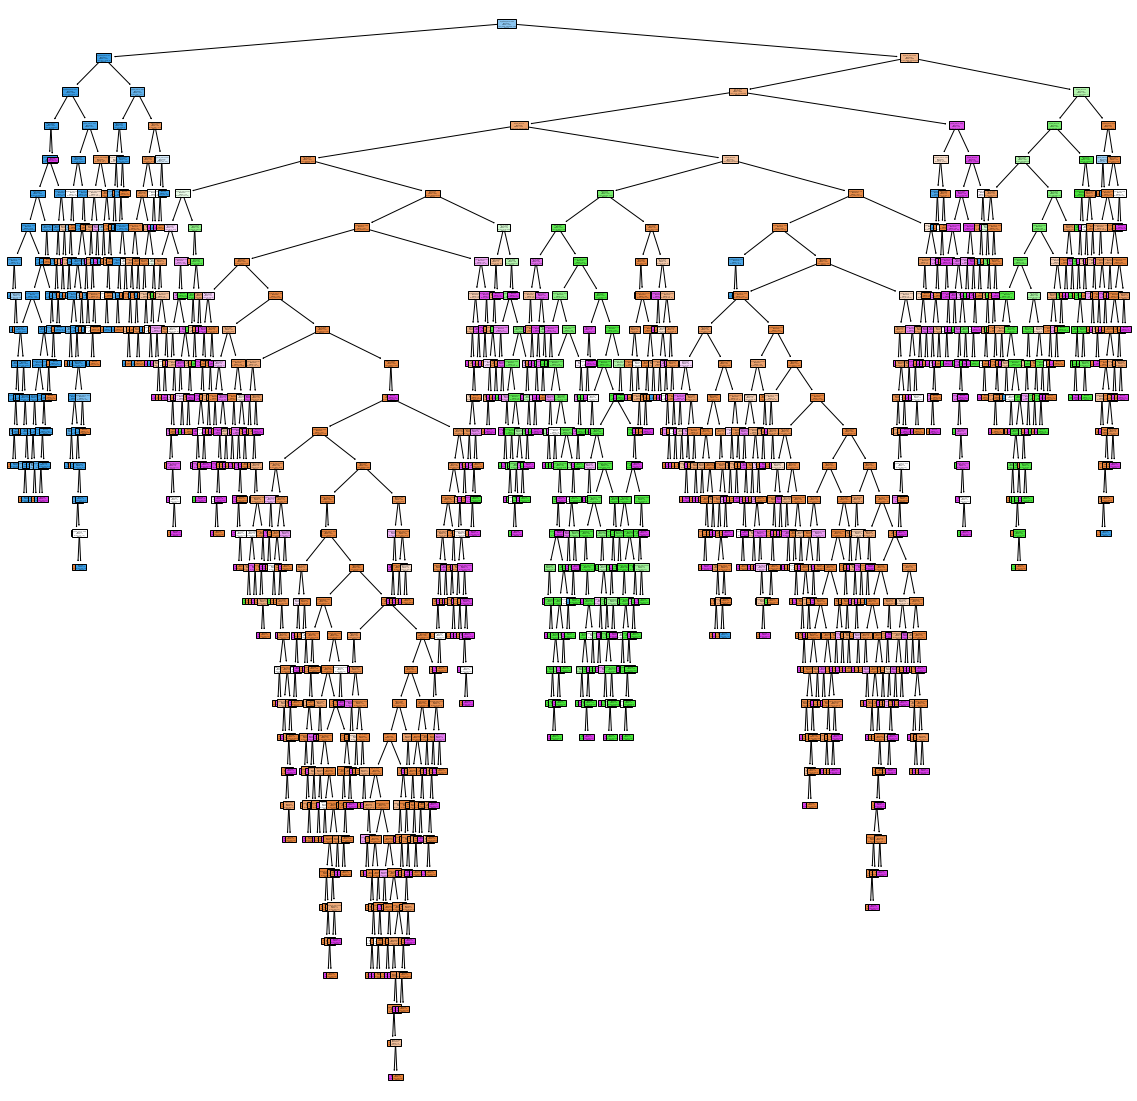

In [31]:
# Printing the Decision tree structure of the model
plt.figure(figsize=(20,20))
tree.plot_tree(dt_model,filled=True, class_names=[str(i) for i in set(y)] ,feature_names=xdt.columns)
plt.savefig('dt_model')

In [33]:
dt_model.score(xdt_test, ydt_test)

0.9888193797417809

In [34]:
#Cost Complexity Pruning Path
path = dt_model.cost_complexity_pruning_path(xdt_train,ydt_train)
ccp_alpha = path.ccp_alphas

In [35]:
path

{'ccp_alphas': array([0.00000000e+00, 8.30171342e-06, 9.47440301e-06, 9.49892391e-06,
        1.05640517e-05, 1.09463036e-05, 1.10042205e-05, 1.10112889e-05,
        1.10540051e-05, 1.10555250e-05, 1.10665778e-05, 1.10714823e-05,
        1.10799841e-05, 1.10800516e-05, 1.10822302e-05, 1.10874875e-05,
        1.11443034e-05, 1.32848611e-05, 1.32875561e-05, 1.33163435e-05,
        1.38653178e-05, 1.42094206e-05, 1.45585837e-05, 1.45585837e-05,
        1.47896724e-05, 1.51258013e-05, 1.52518496e-05, 1.52518496e-05,
        1.57140269e-05, 1.57626771e-05, 1.57626771e-05, 1.58064623e-05,
        1.58460775e-05, 1.58460775e-05, 1.58460775e-05, 1.59149735e-05,
        1.59451155e-05, 1.59984437e-05, 1.60221451e-05, 1.60441535e-05,
        1.60743685e-05, 1.60837687e-05, 1.61016594e-05, 1.61016594e-05,
        1.61629991e-05, 1.61762042e-05, 1.61762042e-05, 1.62325672e-05,
        1.62602364e-05, 1.62843733e-05, 1.63184125e-05, 1.63824063e-05,
        1.63824063e-05, 1.63960749e-05, 1.64202707

In [36]:
#Plotting the score of Decision Tree models with varying CCP alpha values. This is to check which CCP alpha value gives us th ebeest score
dt_models = []
score = []
for i in ccp_alpha:
    dt_m = DecisionTreeClassifier(ccp_alpha = i)
    dt_m.fit(xdt_train,ydt_train)
    dt_models.append(dt_m)
    score.append(dt_m.score(xdt_test, ydt_test))

Text(0, 0.5, 'score')

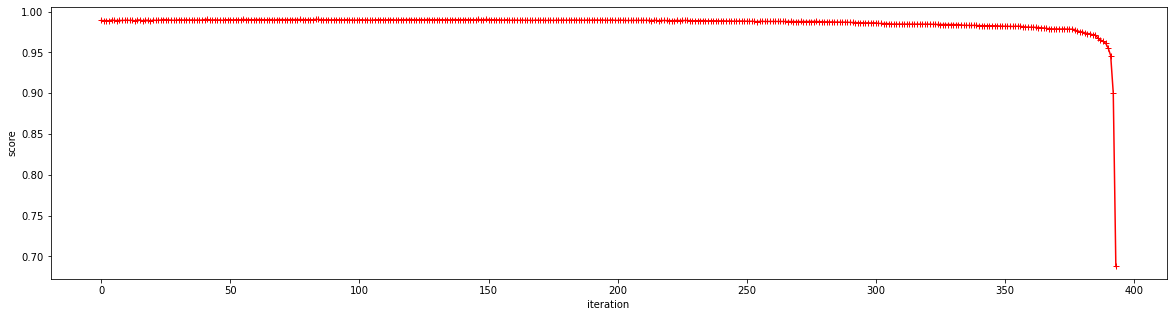

In [37]:
plt.figure(figsize=(20,5))    
plt.plot(score, 'r-+')
plt.xlabel('iteration')
plt.ylabel('score')

In [38]:
train_score = [i.score(xdt_train,ydt_train) for i in dt_models]

In [39]:
test_score = [i.score(xdt_test, ydt_test) for i in dt_models]

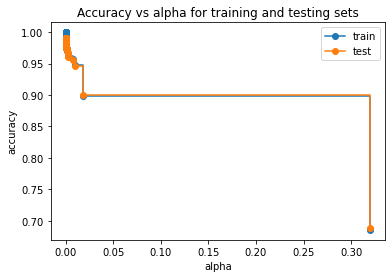

<Figure size 1440x360 with 0 Axes>

In [40]:
#Plotting the ccp aplha values with accuracy of train and test sets
fig, ax = plt.subplots()
plt.figure(figsize=(20,5))
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alpha, train_score, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alpha, test_score, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

_Here we see that the default paramter of ccp_alpha, i.e. 0, is giving us the best accuracy for the model. Hence we use the Decision Tree model with default parameters in this dataset._

### Bagging

In [52]:
from sklearn.ensemble import BaggingClassifier

In [53]:
#Using Decision Tree as the Bagging Classifier
bag_dt = BaggingClassifier(DecisionTreeClassifier() , n_estimators=100)

In [54]:
bag_dt.fit(xdt_train, ydt_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100)

In [55]:
bag_dt.score(xdt_test, ydt_test)

0.9915479834952748

In [56]:
from sklearn.neighbors import KNeighborsClassifier

In [57]:
#Using KNN as the Bagging Classifier
bag_knn = BaggingClassifier(KNeighborsClassifier(6) , n_estimators=10)

In [58]:
bag_knn.fit(x_train,y_train)

BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=6))

In [59]:
bag_knn.score(x_test, y_test)

0.9841607879675229

In [86]:
from sklearn.ensemble import RandomForestClassifier

In [62]:
#Using Random Forest as the Bagging Classifier
rf = RandomForestClassifier(n_estimators=5)

In [63]:
rf.fit(xdt_train, ydt_train)

RandomForestClassifier(n_estimators=5)

In [64]:
rf.score(xdt_test,ydt_test)

0.9898842007187542

__Here we see that using Decision Tree as a bagging classifier has given us the best score uptill now. Therefore we will use it as a final model.__ 

## Stacking

___We will use KNN, SVC and Random Forest models for creating a stacking model. KNN and SVC outputs will be used as inputs for Random Forest model.___

In [75]:
#Splitting the dataset into train and validation sets.
train , val_train , test , val_test  = train_test_split(x,y,test_size = .50 , random_state = 30)

In [76]:
#Now splitting the train set into x and y train and test sets.
x_train , x_test , y_train, y_test = train_test_split(train ,test,random_state = 30 , test_size = .20)

In [77]:
knn = KNeighborsClassifier()
knn.fit(x_train,y_train)

KNeighborsClassifier()

In [78]:
knn.score(x_test,y_test)

C:\Users\Manu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


0.9801677093038733

In [79]:
svc = SVC()
svc.fit(x_train,y_train)

SVC()

In [80]:
svc.score(x_test,y_test)

0.9791028883269001

In [90]:
#Predicting on the validation train sets using KNN and SVC models.
predcition_knn = knn.predict(val_train)
prediction_svc = svc.predict(val_train)

C:\Users\Manu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


In [91]:
#Putting together the KNN and SVC model outputs on validation dataset as an input for Random Forest model.
input3 = np.column_stack((predcition_knn,prediction_svc))

In [92]:
#Using test set of validation data as dependent variable for random forest model.
output = val_test

In [93]:
rf = RandomForestClassifier()

In [94]:
rf.fit(input3,output)

RandomForestClassifier()

In [83]:
rf.predict(input3)

array([1, 3, 3, ..., 3, 3, 3], dtype=int64)

In [95]:
#We will use the prediction of knn and svc models on the test sets of training data to provide as independent variables for testing random forest model
knn_output = knn.predict(x_test)
svc_output = svc.predict(x_test)

C:\Users\Manu\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


In [96]:
output_stack1 = np.column_stack ((knn_output,svc_output))

In [97]:
rf.predict(output_stack1)

array([1, 3, 3, ..., 3, 3, 3], dtype=int64)

In [98]:
rf.score(output_stack1 , y_test)

0.9829628643684281

___After using all the approaches, we find that Bagging Classifier of Decision Tree is the performing model. Hence we will be using it as the final model.___

In [87]:
import pickle
pickle.dump(bag_dt,open('DT_Bagging.pkl' , 'wb'))